# Performing RNA Velocity in the cloud

This notebook demonstrates using `kb-python` to perform an RNA velocity analysis on a human single-cell RNA-seq dataset from La Manno et al. 2018. 

`kb-python` is a python package that wraps the kallisto | bustools single-cell RNA-seq workflow. It was developed by Kyung Hoi (Joseph) Min and A. Sina Booeshaghi.

This analysis is  performed on two datasets from two SRA runs (SRR6470906 and SRR6470907). In order to perform this analysis on Google Colab, we first have to *trick* Colab into giving us more RAM. The RNA velocity index needs 16GB of RAM and a standard Colab notebook comes with only 12GB. The notebook performs the following:

1. Trick the notebook into giving us more RAM by creating a *huge* python list. This breaks the system and allows you to instantiate a new connection with more RAM.

2. Install `kb-python`

3. Download the FASTQ files locally

4. Check that the integrity of the files were maintained by computing the `md5sum`

5. Download and build the velocity index for __HUMAN 10x data__.

6. Pseudoalign and create spliced and unspliced gene count matrices for SRR6470906

7. Pseudoalign and create spliced and unspliced gene count matrices for SRR6470907

8. Install necessary python packages

9. Create a joint anndata object

10. Compare our spliced matrices to those given by La Manno et al.
________________________________
The methods, tools, and data described here are from the following papers: 

* Bray, N. L., Pimentel, H., Melsted, P. & Pachter, L. __Near-optimal probabilistic RNA-seq quantification.__ Nat. Biotechnol. 34, 525–527 (2016).
* Wolf, F. A., Angerer, P. & Theis, F. J. __SCANPY: large-scale single-cell gene expression data analysis.__ Genome Biol. 19, 15 (2018).
* La Manno, Gioele, Ruslan Soldatov, Amit Zeisel, Emelie Braun, Hannah Hochgerner, Viktor Petukhov, Katja Lidschreiber et al. __RNA velocity of single cells.__ Nature 560, no. 7719 (2018): 494.
* Melsted, P., Ntranos, V. & Pachter, L. __The Barcode, UMI, Set format and BUStools.__ Bioinformatics (2019). doi:10.1093/bioinformatics/btz279
* Melsted, P., Booeshaghi, A.S. et al. __Modular and efficient pre-processing of single-cell RNA-seq.__ BioRxiv (2019). doi:10.1101/673285

In [0]:
# Trick the system into giving us more RAM
new_list = [1]*409600000000

## Install `kb-python`

In [1]:
!pip install kb-python==0.24.4

     |████████████████████████████████| 35.4MB 45.6MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
  Created wheel for loompy: filename=loompy-3.0.6-cp36-none-any.whl size=47896 sha256=18cada2e7b3939343b82cbb0fa3300a8ad411be918dd8da5f086e76b594f3dc2
  Stored in directory: /root/.cache/pip/wheels/f9/a4/90/5a98ad83419732b0fba533b81a2a52ba3dbe230a936ca4cdc9
  Created wheel for numpy-groupies: filename=numpy_groupies-0+unknown-cp36-none-any.whl size=27879 sha256=5ff5ee9af1f71243763fbbe95257c7230e3964f45417a3bf64ba251db507fbdc
  Stored in directory: /root/.cache/pip/wheels/6c/fb/3d/5c43eb691bd92a3ddd0ebeb6e7e78ceaf3ae1cb8d54b89a7fb
Successfully built loompy numpy-groupies


## Download FASTQ files (takes about 30 min)

In [2]:
# SRR6470907
!wget https://caltech.box.com/shared/static/l3i8nfh2h1yvcze67v3z4uxymnejsvst.gz -O SRR6470906_S1_L001_R1_001.fastq.gz
!wget https://caltech.box.com/shared/static/3ovi8g86zn21gx37kwors6zvpdrs6d5o.gz -O SRR6470906_S1_L001_R2_001.fastq.gz
!wget https://caltech.box.com/shared/static/jodgdpfx0mo1g4maj4ry2c2yc24pylew.gz -O SRR6470906_S1_L002_R1_001.fastq.gz
!wget https://caltech.box.com/shared/static/nmdq64606laubo0fgml09q8k00y9eecz.gz -O SRR6470906_S1_L002_R2_001.fastq.gz
# SRR6470907
!wget https://caltech.box.com/shared/static/tkgbft2ddfvb6hppqi43qxcs2afmloud.gz -O SRR6470907_S1_L001_R1_001.fastq.gz
!wget https://caltech.box.com/shared/static/dred8n1abiupxfve83w199a724fi7cqt.gz -O SRR6470907_S1_L001_R2_001.fastq.gz
!wget https://caltech.box.com/shared/static/3unr4hf94zp2y2r4ddmzjo7fc78v8hhj.gz -O SRR6470907_S1_L002_R1_001.fastq.gz
!wget https://caltech.box.com/shared/static/fp1pf1dqoizkn93v7t1b0uhje18901cv.gz -O SRR6470907_S1_L002_R2_001.fastq.gz

--2019-11-10 18:27:00--  https://caltech.box.com/shared/static/l3i8nfh2h1yvcze67v3z4uxymnejsvst.gz
Resolving caltech.box.com (caltech.box.com)... 107.152.26.197, 107.152.27.197
Connecting to caltech.box.com (caltech.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/l3i8nfh2h1yvcze67v3z4uxymnejsvst.gz [following]
--2019-11-10 18:27:00--  https://caltech.box.com/public/static/l3i8nfh2h1yvcze67v3z4uxymnejsvst.gz
Reusing existing connection to caltech.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://caltech.app.box.com/public/static/l3i8nfh2h1yvcze67v3z4uxymnejsvst.gz [following]
--2019-11-10 18:27:00--  https://caltech.app.box.com/public/static/l3i8nfh2h1yvcze67v3z4uxymnejsvst.gz
Resolving caltech.app.box.com (caltech.app.box.com)... 107.152.27.199, 107.152.26.199
Connecting to caltech.app.box.com (caltech.app.box.com)|107.152.27.199|:443... connected.
HTTP request s

## Download the checksum to verify that the FASTQs were not corrupted during download

In [8]:
!wget -O checksum_velocity.txt https://caltech.box.com/shared/static/7ex8lgiwyx6i5jggp6uylc1h9eu4dy8j.txt

--2019-11-10 19:06:50--  https://caltech.box.com/shared/static/7ex8lgiwyx6i5jggp6uylc1h9eu4dy8j.txt
Resolving caltech.box.com (caltech.box.com)... 107.152.27.197, 107.152.26.197
Connecting to caltech.box.com (caltech.box.com)|107.152.27.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/7ex8lgiwyx6i5jggp6uylc1h9eu4dy8j.txt [following]
--2019-11-10 19:06:50--  https://caltech.box.com/public/static/7ex8lgiwyx6i5jggp6uylc1h9eu4dy8j.txt
Reusing existing connection to caltech.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://caltech.app.box.com/public/static/7ex8lgiwyx6i5jggp6uylc1h9eu4dy8j.txt [following]
--2019-11-10 19:06:50--  https://caltech.app.box.com/public/static/7ex8lgiwyx6i5jggp6uylc1h9eu4dy8j.txt
Resolving caltech.app.box.com (caltech.app.box.com)... 107.152.27.199, 107.152.26.199
Connecting to caltech.app.box.com (caltech.app.box.com)|107.152.27.199|:443... connected.
HTTP requ

## Compute the `md5sum` for the FASTQs that you downloaded

In [3]:
!md5sum SRR*

54e279b3579f4510ceaa5b2fabf765dd  SRR6470906_S1_L001_R1_001.fastq.gz
bf17464207221323654f632b7e510bf7  SRR6470906_S1_L001_R2_001.fastq.gz
93ed60fffadb0e6fcbfd3de7bef6fcf9  SRR6470906_S1_L002_R1_001.fastq.gz
71399836e3df48986367d1b8e406c49f  SRR6470906_S1_L002_R2_001.fastq.gz
f673319f9de59b558c09060df1a903f9  SRR6470907_S1_L001_R1_001.fastq.gz
d81642bdb6895da047f6972efbfcd088  SRR6470907_S1_L001_R2_001.fastq.gz
ac5b155e574dd7a2bcc940376b613cd6  SRR6470907_S1_L002_R1_001.fastq.gz
c7c7076a43722a9b2b1fc42463d2e499  SRR6470907_S1_L002_R2_001.fastq.gz


## Print out what the `md5sums` should be (same as above!)

In [5]:
!cat checksum_velocity.txt

54e279b3579f4510ceaa5b2fabf765dd  SRR6470906_S1_L001_R1_001.fastq.gz
bf17464207221323654f632b7e510bf7  SRR6470906_S1_L001_R2_001.fastq.gz
93ed60fffadb0e6fcbfd3de7bef6fcf9  SRR6470906_S1_L002_R1_001.fastq.gz
71399836e3df48986367d1b8e406c49f  SRR6470906_S1_L002_R2_001.fastq.gz
f673319f9de59b558c09060df1a903f9  SRR6470907_S1_L001_R1_001.fastq.gz
d81642bdb6895da047f6972efbfcd088  SRR6470907_S1_L001_R2_001.fastq.gz
ac5b155e574dd7a2bcc940376b613cd6  SRR6470907_S1_L002_R1_001.fastq.gz
c7c7076a43722a9b2b1fc42463d2e499  SRR6470907_S1_L002_R2_001.fastq.gz


## Download and build the __HUMAN__ velocity index (suitable for 10x data only.)

See this notebook to understand how the index was created:
https://github.com/linnarsson-lab/loompy/blob/master/notebooks/build_index.ipynb

In [9]:
!time kb ref -d linnarsson -i index.idx -g transcripts_to_genes.txt \
-c1 cdna_transcripts_to_capture.txt -c2 intron_transcripts_to_capture.txt

[2019-11-10 19:07:09,192]    INFO Downloading files for linnarsson from https://caltech.box.com/shared/static/kyf7ai5s8y2l0vycl5yxunrappvrf0yx.gz to tmp/kyf7ai5s8y2l0vycl5yxunrappvrf0yx.gz
[2019-11-10 19:11:05,472]    INFO Extracting files from tmp/kyf7ai5s8y2l0vycl5yxunrappvrf0yx.gz

real	5m12.457s
user	1m25.980s
sys	0m30.618s


## Make the `spliced` and `unspliced` count matrices as `adata.h5ad` object (for SRR6470906)

__Note:__ If you were running RNA velocity without a reference dataset to compare to, I recommend adding the `--filter` option to `kb count`

In [10]:
!time kb count --h5ad -i index.idx -g transcripts_to_genes.txt -x 10xv2 -o SRR6470906 \
-c1 cdna_transcripts_to_capture.txt -c2 intron_transcripts_to_capture.txt --lamanno \
SRR6470906_S1_L001_R1_001.fastq.gz \
SRR6470906_S1_L001_R2_001.fastq.gz \
SRR6470906_S1_L002_R1_001.fastq.gz \
SRR6470906_S1_L002_R2_001.fastq.gz

[2019-11-10 19:13:53,953]    INFO Generating BUS file from
[2019-11-10 19:13:53,953]    INFO         SRR6470906_S1_L001_R1_001.fastq.gz
[2019-11-10 19:13:53,953]    INFO         SRR6470906_S1_L001_R2_001.fastq.gz
[2019-11-10 19:13:53,953]    INFO         SRR6470906_S1_L002_R1_001.fastq.gz
[2019-11-10 19:13:53,953]    INFO         SRR6470906_S1_L002_R2_001.fastq.gz
[2019-11-10 19:37:27,550]    INFO Sorting BUS file SRR6470906/output.bus to tmp/output.s.bus
[2019-11-10 19:39:03,495]    INFO Whitelist not provided
[2019-11-10 19:39:03,495]    INFO Copying pre-packaged 10XV2 whitelist to SRR6470906
[2019-11-10 19:39:03,610]    INFO Inspecting BUS file tmp/output.s.bus
[2019-11-10 19:39:37,271]    INFO Correcting BUS records in tmp/output.s.bus to tmp/output.s.c.bus with whitelist SRR6470906/10xv2_whitelist.txt
[2019-11-10 19:40:07,090]    INFO Sorting BUS file tmp/output.s.c.bus to SRR6470906/output.unfiltered.bus
[2019-11-10 19:40:39,452]    INFO Capturing records from BUS file SRR6470906

## Make the `spliced` and `unspliced` count matrices as `adata.h5ad` object (for SRR6470907)

__Note:__ If you were running RNA velocity without a reference dataset to compare to, I recommend adding the `--filter` option to `kb count`

In [12]:
!time kb count --h5ad -i index.idx -g transcripts_to_genes.txt -x 10xv2 -o SRR6470907 \
-c1 cdna_transcripts_to_capture.txt -c2 intron_transcripts_to_capture.txt --lamanno \
SRR6470907_S1_L001_R1_001.fastq.gz \
SRR6470907_S1_L001_R2_001.fastq.gz \
SRR6470907_S1_L002_R1_001.fastq.gz \
SRR6470907_S1_L002_R2_001.fastq.gz

[2019-11-10 19:45:55,412]    INFO Generating BUS file from
[2019-11-10 19:45:55,412]    INFO         SRR6470907_S1_L001_R1_001.fastq.gz
[2019-11-10 19:45:55,412]    INFO         SRR6470907_S1_L001_R2_001.fastq.gz
[2019-11-10 19:45:55,412]    INFO         SRR6470907_S1_L002_R1_001.fastq.gz
[2019-11-10 19:45:55,412]    INFO         SRR6470907_S1_L002_R2_001.fastq.gz
[2019-11-10 20:11:19,138]    INFO Sorting BUS file SRR6470907/output.bus to tmp/output.s.bus
[2019-11-10 20:13:05,006]    INFO Whitelist not provided
[2019-11-10 20:13:05,006]    INFO Copying pre-packaged 10XV2 whitelist to SRR6470907
[2019-11-10 20:13:05,117]    INFO Inspecting BUS file tmp/output.s.bus
[2019-11-10 20:13:46,512]    INFO Correcting BUS records in tmp/output.s.bus to tmp/output.s.c.bus with whitelist SRR6470907/10xv2_whitelist.txt
[2019-11-10 20:14:19,823]    INFO Sorting BUS file tmp/output.s.c.bus to SRR6470907/output.unfiltered.bus
[2019-11-10 20:15:01,393]    INFO Capturing records from BUS file SRR6470907

## Install necessary python packages

In [13]:
!pip install scanpy loompy scvelo anndata velocyto

     |████████████████████████████████| 1.9MB 2.8MB/s 
     |████████████████████████████████| 174kB 51.5MB/s 
     |████████████████████████████████| 204kB 56.2MB/s 
     |████████████████████████████████| 3.6MB 33.6MB/s 
     |████████████████████████████████| 13.0MB 26.0MB/s 
     |████████████████████████████████| 3.2MB 25.1MB/s 
  Created wheel for velocyto: filename=velocyto-0.17.17-cp36-cp36m-linux_x86_64.whl size=368172 sha256=456671e64ba6b8478aa50939673b02abf46f8af7e13032241e081c747800bc09
  Stored in directory: /root/.cache/pip/wheels/e0/10/47/5a2aa6a7179b17b50a19cdba1df71798ade77e7d9ce98c5300
  Created wheel for pysam: filename=pysam-0.15.3-cp36-cp36m-linux_x86_64.whl size=8789870 sha256=fabada925f0c8268d656b9b1fa989572879157dfdd145234b6c9b10d959ed190
  Stored in directory: /root/.cache/pip/wheels/85/ab/84/86ca6dda37a6fc85687b67be7345b735cd82f6584bea56f327
Successfully built velocyto pysam
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have img

# Perform downstream analysis

In [30]:
import scanpy as sc
import numpy as np
import scipy as scp
import sklearn
import matplotlib.pyplot as plt
import matplotlib
import sys
import loompy
import scipy.optimize
import velocyto as vcy
import scvelo as scv
import glob
import pickle
import anndata
import scanpy 

from collections import Counter
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))
matplotlib.rcParams.update({'font.size': 22})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Download the published matrix

In [2]:
them = scv.read('data/hgForebrainGlut.loom', cleanup=True, sparse=True, cache=True, backup_url='http://pklab.med.harvard.edu/velocyto/hgForebrainGlut/hgForebrainGlut.loom')
them.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Clean it up so that we can compare it to ours

In [0]:
them.obs["bcs"] = them.obs.index.str.slice(11,-1)
them.obs["bid"] = them.obs.index.str.slice(8,10)
them.obs["run"] = them.obs.bid.map(lambda x: "06" if x=="29" else "07")
them.obs.index = them.obs.bcs.values + "."+ them.obs["run"]


### Load matrix `06` and `07`

In [0]:
a06 = anndata.read_h5ad("/content/SRR6470906/counts_unfiltered/adata.h5ad")
a07 = anndata.read_h5ad("/content/SRR6470907/counts_unfiltered/adata.h5ad")

In [0]:
a06.obs["run"] = "06"
a07.obs["run"] = "07"

In [0]:
a06.obs["bcs"] = a06.obs.index
a07.obs["bcs"] = a07.obs.index

In [0]:
a06.obs.index = a06.obs["bcs"] + "." + a06.obs["run"]
a07.obs.index = a07.obs["bcs"] + "." + a07.obs["run"]

### Make a single anndata object with both `06` and `07`

In [0]:
adata = a06.concatenate(a07, batch_key="batch")

In [67]:
adata.obs.head()

,batch,bcs,run
AAACCTGAGAAACCGC.06-0,0,AAACCTGAGAAACCGC,06
AAACCTGAGAAGGACA.06-0,0,AAACCTGAGAAGGACA,06
AAACCTGAGAAGGCCT.06-0,0,AAACCTGAGAAGGCCT,06
AAACCTGAGAAGGGTA.06-0,0,AAACCTGAGAAGGGTA,06
AAACCTGAGAAGGTTT.06-0,0,AAACCTGAGAAGGTTT,06


In [0]:
adata.obs.index = adata.obs.index.str.slice(0, 19)

In [0]:
adata.var.index = adata.var.index.str.slice(0, 15)

In [70]:
adata.obs

,batch,bcs,run
AAACCTGAGAAACCGC.06,0,AAACCTGAGAAACCGC,06
AAACCTGAGAAGGACA.06,0,AAACCTGAGAAGGACA,06
AAACCTGAGAAGGCCT.06,0,AAACCTGAGAAGGCCT,06
AAACCTGAGAAGGGTA.06,0,AAACCTGAGAAGGGTA,06
AAACCTGAGAAGGTTT.06,0,AAACCTGAGAAGGTTT,06
...,...,...,...
TTTGTCATCTTCGGTC.07,1,TTTGTCATCTTCGGTC,07
TTTGTCATCTTGTCAT.07,1,TTTGTCATCTTGTCAT,07
TTTGTCATCTTTACAC.07,1,TTTGTCATCTTTACAC,07
TTTGTCATCTTTACGT.07,1,TTTGTCATCTTTACGT,07


In [71]:
them.obs

,Clusters,bcs,bid,run
run,,,,
AACCATGGTAATCACC.07,3,AACCATGGTAATCACC,28,07
AACCATGCATACTACG.07,3,AACCATGCATACTACG,28,07
AAACCTGGTAAAGGAG.07,1,AAACCTGGTAAAGGAG,28,07
AAAGTAGCAAAGTCAA.07,0,AAAGTAGCAAAGTCAA,28,07
AAAGCAACAAACGCGA.07,3,AAAGCAACAAACGCGA,28,07
...,...,...,...,...
TTTATGCGTTGCGCAC.06,0,TTTATGCGTTGCGCAC,29,06
TTTGCGCGTTCCGTCT.06,3,TTTGCGCGTTCCGTCT,29,06
TTTGGTTGTACCCAAT.06,6,TTTGGTTGTACCCAAT,29,06


# Select the right barcodes and genes

In [0]:
final = adata[adata.obs.index.isin(them.obs.index),:]
final = final[:,final.var.index.isin(them.var.Accession)]

In [73]:
final

View of AnnData object with n_obs × n_vars = 1720 × 31029 
    obs: 'batch', 'bcs', 'run'
    layers: 'spliced', 'unspliced'

In [74]:
final.layers["ambiguous"] = scp.sparse.csr_matrix(np.zeros(final.X.shape))


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [0]:
final.obs["CellID"] = final.obs.index
final.obs["Clusters"] = final.obs.index.map(them.obs["Clusters"])
final.var["Accession"] = final.var.index

In [76]:
final.obs.head()

,batch,bcs,run,CellID,Clusters
AAACGGGAGATTACCC.06,0,AAACGGGAGATTACCC,06,AAACGGGAGATTACCC.06,6
AAACGGGTCGCTAGCG.06,0,AAACGGGTCGCTAGCG,06,AAACGGGTCGCTAGCG.06,5
AAATGCCTCTAACTCT.06,0,AAATGCCTCTAACTCT,06,AAATGCCTCTAACTCT.06,4
AACACGTAGGTAGCCA.06,0,AACACGTAGGTAGCCA,06,AACACGTAGGTAGCCA.06,5
AACACGTCATTACGAC.06,0,AACACGTCATTACGAC,06,AACACGTCATTACGAC.06,5


In [77]:
scv.pp.show_proportions(final)
print(final)

Abundance of ['spliced', 'unspliced', 'ambiguous']: [0.61 0.39 0.  ]
AnnData object with n_obs × n_vars = 1720 × 31029 
    obs: 'batch', 'bcs', 'run', 'CellID', 'Clusters'
    var: 'Accession'
    layers: 'spliced', 'unspliced', 'ambiguous'


### Save the `final` anndata as a loom file

In [0]:
final.write_loom("data/final.loom")

# Run the veocyto python pipeline

### __Note:__ because Google Colab doesn't support `R`, we cannot run `princurve = importr("princurve", on_conflict="warn")`

In [0]:
# Wrap implementation
import rpy2.robjects as robj
from rpy2.robjects.packages import importr

def array_to_rmatrix(X):
    nr, nc = X.shape
    xvec = robj.FloatVector(X.transpose().reshape((X.size)))
    xr = robj.r.matrix(xvec, nrow=nr, ncol=nc)
    return xr

def principal_curve(X, pca=True):
    """
    input : numpy.array
    returns:
    Result::Object
        Methods:
        projections - the matrix of the projectiond
        ixsort - the order ot the points (as in argsort)
        arclength - the lenght of the arc from the beginning to the point
    """
    # convert array to R matrix
    xr = array_to_rmatrix(X)
    
    if pca:
        #perform pca
        t = robj.r.prcomp(xr)
        #determine dimensionality reduction
        usedcomp = max( sum( np.array(t[t.names.index('sdev')]) > 1.1) , 4)
        usedcomp = min([usedcomp, sum( np.array(t[t.names.index('sdev')]) > 0.25), X.shape[0]])
        Xpc = np.array(t[t.names.index('x')])[:,:usedcomp]
        # convert array to R matrix
        xr = array_to_rmatrix(Xpc)

    #import the correct namespace
    princurve = importr("princurve", on_conflict="warn")
    
    #call the function
    fit1 = princurve.principal_curve(xr)
    
    #extract the outputs
    class Results:
        pass
    results = Results()
    results.projections = np.array( fit1[0] )
    results.ixsort = np.array( fit1[1] ) - 1 # R is 1 indexed
    results.arclength = np.array( fit1[2] )
    results.dist = np.array( fit1[3] )
    
    if pca:
        results.PCs = np.array(xr) #only the used components
        
    return results

In [55]:
princurve = importr("princurve", on_conflict="warn")


RRuntimeError: ignored

### Load the velocity loom file that we saved earlier

In [0]:
vlm = vcy.VelocytoLoom("./data/final.loom")


### The rest of the notebook comes from the following notebook:
https://github.com/velocyto-team/velocyto-notebooks/blob/master/python/hgForebrainGlutamatergic.ipynb

In [0]:
labels = vlm.ca["Clusters"]
manual_annotation = {str(i):[i] for i in labels}
annotation_dict = {v:k for k, values in manual_annotation.items() for v in values }
clusters = np.array([annotation_dict[i] for i in labels])
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))
vlm.set_clusters(clusters, cluster_colors_dict={k:colors20[v[0] % 20,:] for k,v in manual_annotation.items()})

In [0]:
# just to find the initial cell size
vlm.normalize("S", size=True, log=False)
vlm.normalize("U", size=True,  log=False)

In [0]:
vlm.score_detection_levels(min_expr_counts=30, min_cells_express=20,
                           min_expr_counts_U=0, min_cells_express_U=0)
vlm.filter_genes(by_detection_levels=True)

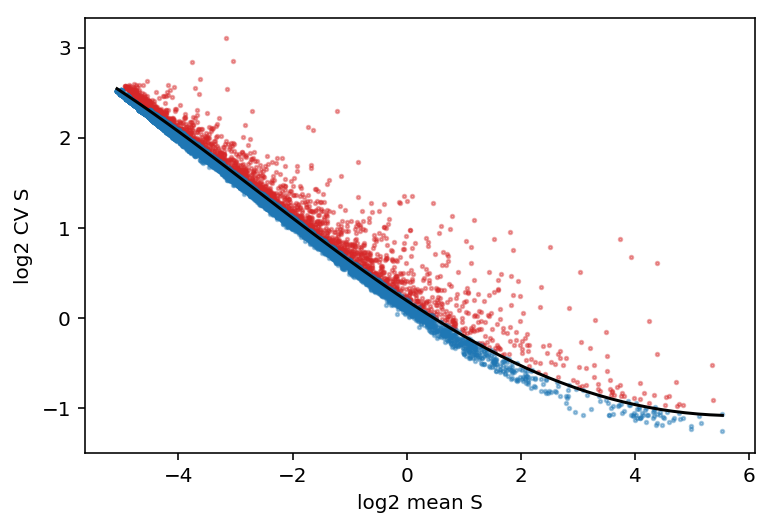

In [85]:
vlm.score_cv_vs_mean(2000, plot=True, max_expr_avg=50, winsorize=True, winsor_perc=(1,99.8), svr_gamma=0.01, min_expr_cells=50)
vlm.filter_genes(by_cv_vs_mean=True)

In [0]:

vlm.score_detection_levels(min_expr_counts=0, min_cells_express=0,
                           min_expr_counts_U=25, min_cells_express_U=20)
vlm.score_cluster_expression(min_avg_U=0.007, min_avg_S=0.06)
vlm.filter_genes(by_detection_levels=True, by_cluster_expression=True)
vlm.normalize_by_total(min_perc_U=0.5)
vlm.adjust_totS_totU(normalize_total=True, fit_with_low_U=False, svr_C=1, svr_gamma=1e-04)

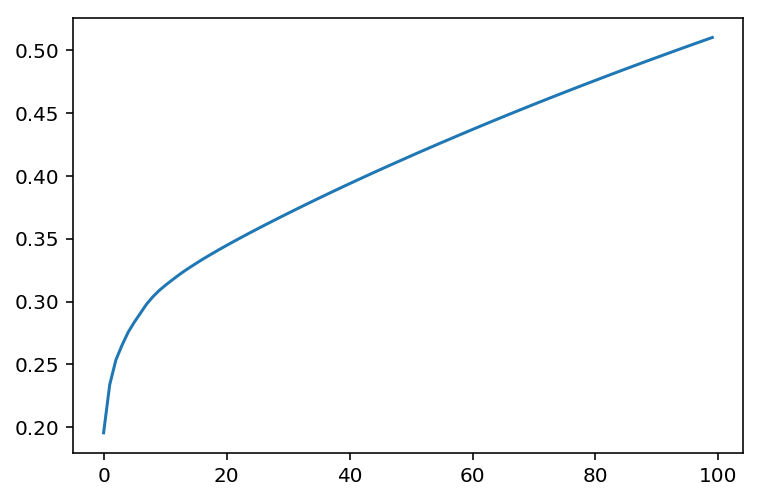

In [87]:
vlm.perform_PCA()
plt.plot(np.cumsum(vlm.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.0055))[0][0]
vlm.pcs[:,1] *= -1 # flip for consistency with previous version

In [91]:
!pip install python-igraph

     |████████████████████████████████| 378kB 2.8MB/s 
  Created wheel for python-igraph: filename=python_igraph-0.7.1.post6-cp36-cp36m-linux_x86_64.whl size=2220544 sha256=93478b3bd1ae89240e407d116b61fa1e5741133c9735f5fee3c6689b4123506a
  Stored in directory: /root/.cache/pip/wheels/41/d6/02/34eebae97e25f5b87d60f4c0687e00523e3f244fa41bc3f4a7
Successfully built python-igraph


In [0]:
from sklearn.neighbors import NearestNeighbors
import igraph
nn = NearestNeighbors(50)
nn.fit(vlm.pcs[:,:4])
knn_pca = nn.kneighbors_graph(mode='distance')
knn_pca = knn_pca.tocoo()
G = igraph.Graph(list(zip(knn_pca.row, knn_pca.col)), directed=False, edge_attrs={'weight': knn_pca.data})
VxCl = G.community_multilevel(return_levels=False, weights="weight")
labels = np.array(VxCl.membership)

In [0]:
annotation_dict = {v:k for k, values in manual_annotation.items() for v in values }
clusters = np.array([annotation_dict[i] for i in labels])
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))
vlm.set_clusters(clusters, cluster_colors_dict={k:colors20[v[0] % 20,:] for k,v in manual_annotation.items()})

In [0]:
k = 550
vlm.knn_imputation(n_pca_dims=n_comps,k=k)

In [0]:
vlm.normalize_median()
vlm.fit_gammas(maxmin_perc=[2,95], limit_gamma=True)

In [0]:
vlm.normalize(which="imputed", size=False, log=True)
vlm.Pcs = np.array(vlm.pcs[:,:2], order="C")

In [0]:
vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift()
vlm.extrapolate_cell_at_t(delta_t=1)

In [108]:
vlm.estimate_transition_prob(hidim="Sx_sz", embed="Pcs", transform="log", psc=1,
                             n_neighbors=150, knn_random=True, sampled_fraction=1)

In [0]:
vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)


In [0]:
vlm.calculate_grid_arrows(smooth=0.9, steps=(25, 25), n_neighbors=200)


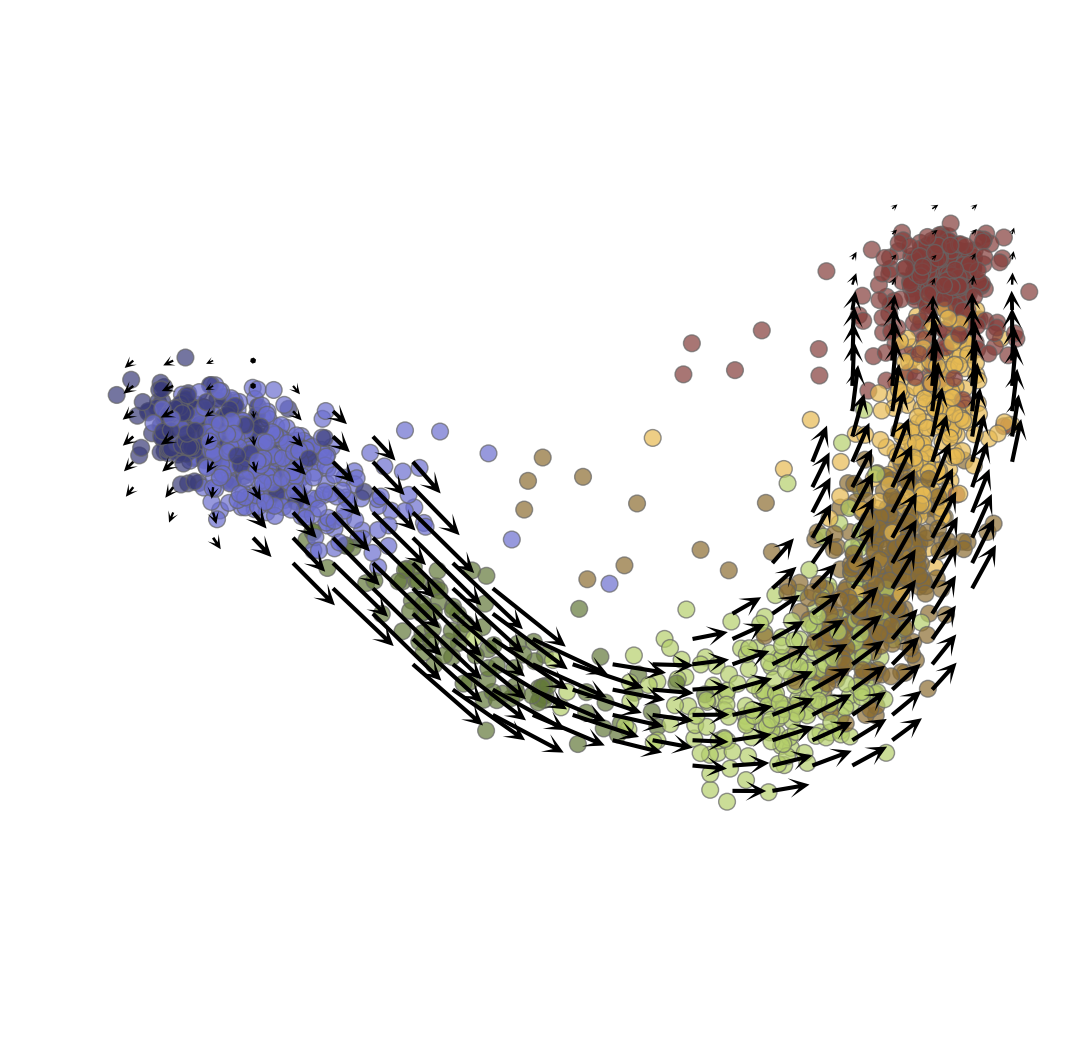

In [112]:

plt.figure(None,(9,9))
vlm.plot_grid_arrows(scatter_kwargs_dict={"alpha":0.7, "lw":0.7, "edgecolor":"0.4", "s":70, "rasterized":True},
                     min_mass=2.9, angles='xy', scale_units='xy',
                     headaxislength=2.75, headlength=5, headwidth=4.8, quiver_scale=0.35, scale_type="absolute")
#plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="w", lw=6, zorder=1000000)
#plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="k", lw=3, zorder=2000000)
plt.gca().invert_xaxis()
plt.axis("off")
plt.axis("equal");
#plt.savefig("kallisto_velocity_forebrain_glut.pdf")